### Welcome to the backend experimentation notebook

This notebook makes use of the clean data produced by the cleaning experimentation notebook to come up with a clustering algorithm that can be turned into the modular cluster file.

In [126]:
# importing everything
import numpy as np
import pandas as pd
import csv
import datetime as dt
import matplotlib.pyplot as plt

In [127]:
df = pd.read_csv('datasets/crimedata2016.csv')
df.head()

,Date,Primary Type,Description,Location Description,Arrest,Domestic,Beat,FBI Code,X Coordinate,Y Coordinate,Year,Location,Latitude,Longitude
0,05/03/2016 11:40:00 PM,BATTERY,DOMESTIC BATTERY SIMPLE,APARTMENT,True,True,1022,08B,1154907.0,1893681.0,2016,"[41.864073157, -87.706818608]",41.864073,-87.706819
1,05/03/2016 09:40:00 PM,BATTERY,DOMESTIC BATTERY SIMPLE,RESIDENCE,False,True,313,08B,1183066.0,1864330.0,2016,"[41.782921527, -87.60436317]",41.782922,-87.604363
2,05/03/2016 11:31:00 PM,PUBLIC PEACE VIOLATION,RECKLESS CONDUCT,STREET,False,False,1524,24,1140789.0,1904819.0,2016,"[41.894908283, -87.758371958]",41.894908,-87.758372
3,05/03/2016 10:10:00 PM,BATTERY,SIMPLE,SIDEWALK,False,False,1532,08B,1143223.0,1901475.0,2016,"[41.885686845, -87.749515983]",41.885687,-87.749516
4,05/03/2016 10:00:00 PM,THEFT,$500 AND UNDER,RESIDENCE,False,True,1523,06,1139890.0,1901675.0,2016,"[41.886297242, -87.761750709]",41.886297,-87.761751


In [128]:
timelist = []
for i in range(len(df)):
    datetime_object = dt.datetime.strptime(df['Date'][i][-11:], '%I:%M:%S %p')
    timelist.append(datetime_object)
df['Time'] = timelist
df.head()

,Date,Primary Type,Description,Location Description,Arrest,Domestic,Beat,FBI Code,X Coordinate,Y Coordinate,Year,Location,Latitude,Longitude,Time
0,05/03/2016 11:40:00 PM,BATTERY,DOMESTIC BATTERY SIMPLE,APARTMENT,True,True,1022,08B,1154907.0,1893681.0,2016,"[41.864073157, -87.706818608]",41.864073,-87.706819,1900-01-01 23:40:00
1,05/03/2016 09:40:00 PM,BATTERY,DOMESTIC BATTERY SIMPLE,RESIDENCE,False,True,313,08B,1183066.0,1864330.0,2016,"[41.782921527, -87.60436317]",41.782922,-87.604363,1900-01-01 21:40:00
2,05/03/2016 11:31:00 PM,PUBLIC PEACE VIOLATION,RECKLESS CONDUCT,STREET,False,False,1524,24,1140789.0,1904819.0,2016,"[41.894908283, -87.758371958]",41.894908,-87.758372,1900-01-01 23:31:00
3,05/03/2016 10:10:00 PM,BATTERY,SIMPLE,SIDEWALK,False,False,1532,08B,1143223.0,1901475.0,2016,"[41.885686845, -87.749515983]",41.885687,-87.749516,1900-01-01 22:10:00
4,05/03/2016 10:00:00 PM,THEFT,$500 AND UNDER,RESIDENCE,False,True,1523,06,1139890.0,1901675.0,2016,"[41.886297242, -87.761750709]",41.886297,-87.761751,1900-01-01 22:00:00


In [129]:
cleandf = df.drop(['Date', 'X Coordinate', 'Y Coordinate', 'Beat', 'Year', 'FBI Code'], axis=1)
cleandf.head()

,Primary Type,Description,Location Description,Arrest,Domestic,Location,Latitude,Longitude,Time
0,BATTERY,DOMESTIC BATTERY SIMPLE,APARTMENT,True,True,"[41.864073157, -87.706818608]",41.864073,-87.706819,1900-01-01 23:40:00
1,BATTERY,DOMESTIC BATTERY SIMPLE,RESIDENCE,False,True,"[41.782921527, -87.60436317]",41.782922,-87.604363,1900-01-01 21:40:00
2,PUBLIC PEACE VIOLATION,RECKLESS CONDUCT,STREET,False,False,"[41.894908283, -87.758371958]",41.894908,-87.758372,1900-01-01 23:31:00
3,BATTERY,SIMPLE,SIDEWALK,False,False,"[41.885686845, -87.749515983]",41.885687,-87.749516,1900-01-01 22:10:00
4,THEFT,$500 AND UNDER,RESIDENCE,False,True,"[41.886297242, -87.761750709]",41.886297,-87.761751,1900-01-01 22:00:00


In [130]:
# using sklearn's label encoder for more complex encoders where severity isn't needed
from sklearn import preprocessing as pp
lp = pp.LabelEncoder()
op = pp.OrdinalEncoder()
# creating a manual encoder for descriptions
basicCrime = list(set(cleandf['Primary Type']))
basicCrime

['NARCOTICS',
 'STALKING',
 'SEX OFFENSE',
 'MOTOR VEHICLE THEFT',
 'ROBBERY',
 'OTHER NARCOTIC VIOLATION',
 'GAMBLING',
 'BATTERY',
 'CRIMINAL DAMAGE',
 'HUMAN TRAFFICKING',
 'ASSAULT',
 'DECEPTIVE PRACTICE',
 'NON-CRIMINAL',
 'OTHER OFFENSE',
 'WEAPONS VIOLATION',
 'BURGLARY',
 'INTERFERENCE WITH PUBLIC OFFICER',
 'PROSTITUTION',
 'ARSON',
 'KIDNAPPING',
 'CRIMINAL TRESPASS',
 'INTIMIDATION',
 'NON-CRIMINAL (SUBJECT SPECIFIED)',
 'LIQUOR LAW VIOLATION',
 'THEFT',
 'HOMICIDE',
 'OFFENSE INVOLVING CHILDREN',
 'PUBLIC PEACE VIOLATION',
 'CONCEALED CARRY LICENSE VIOLATION',
 'OBSCENITY',
 'CRIM SEXUAL ASSAULT',
 'NON - CRIMINAL',
 'PUBLIC INDECENCY']

In [131]:
# manual encoding of crimes based on severity
# in order to generate a heatmap of which areas are the most dangerous
primList = {'NON - CRIMINAL': 0, 'NON-CRIMINAL (SUBJECT SPECIFIED)': 0, 'NON-CRIMINAL': 0,
            'INTIMIDATION': 1, 'OBSCENITY': 1, 'OTHER OFFENSE': 1, 'PUBLIC INDECENCY': 1,
            'LIQUOR LAW VIOLATION': 2, 'PUBLIC PEACE VIOLATION': 2, 'CONCEALED CARRY LICENSE VIOLATION': 2,
            'PROSTITUTION': 3, 'GAMBLING': 3, 'INTERFERENCE WITH PUBLIC OFFICER': 3, 'STALKING': 3,
            'ARSON': 6, 'BURGLARY': 5, 'BATTERY': 2, 'ROBBERY': 5, 'SEX OFFENSE': 5, 'ASSAULT': 3,
            'THEFT': 4, 'DECEPTIVE PRACTICE': 5, 'CRIMINAL TRESPASS': 4, 'CRIMINAL DAMAGE': 4, 'WEAPONS VIOLATION' : 5,
            'MOTOR VEHICLE THEFT': 5, 'OFFENSE INVOLVING CHILDREN': 5, 'KIDNAPPING': 5, 'NARCOTICS': 5,
            'OTHER NARCOTIC VIOLATION' : 4,'HUMAN TRAFFICKING' : 6,'CRIM SEXUAL ASSAULT' : 6, 'HOMICIDE' : 6}
len(primList)

33

In [132]:
# running the encode, along with the other encoders and adding them all to the dataframe
encodePrim = [primList[i] for i in cleandf['Primary Type']]
cleandf['desc'] = lp.fit_transform(cleandf['Description'])
cleandf['locdesc'] = lp.fit_transform(cleandf['Location Description'])
cleandf['type'] = encodePrim
cleandf.head()

,Primary Type,Description,Location Description,Arrest,Domestic,Location,Latitude,Longitude,Time,desc,locdesc,type
0,BATTERY,DOMESTIC BATTERY SIMPLE,APARTMENT,True,True,"[41.864073157, -87.706818608]",41.864073,-87.706819,1900-01-01 23:40:00,104,17,2
1,BATTERY,DOMESTIC BATTERY SIMPLE,RESIDENCE,False,True,"[41.782921527, -87.60436317]",41.782922,-87.604363,1900-01-01 21:40:00,104,99,2
2,PUBLIC PEACE VIOLATION,RECKLESS CONDUCT,STREET,False,False,"[41.894908283, -87.758371958]",41.894908,-87.758372,1900-01-01 23:31:00,234,114,2
3,BATTERY,SIMPLE,SIDEWALK,False,False,"[41.885686845, -87.749515983]",41.885687,-87.749516,1900-01-01 22:10:00,251,111,2
4,THEFT,$500 AND UNDER,RESIDENCE,False,True,"[41.886297242, -87.761750709]",41.886297,-87.761751,1900-01-01 22:00:00,0,99,4


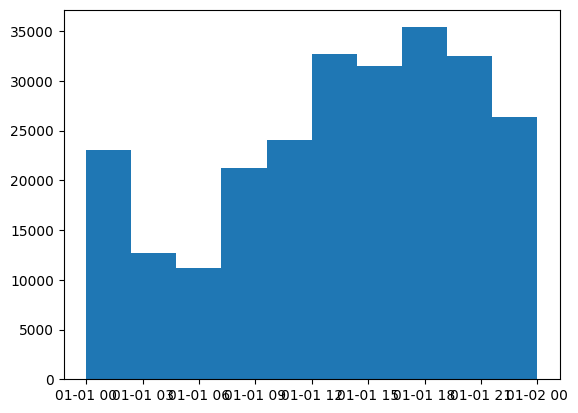

In [133]:
# for fun, the time histogram follows a normal distribution
plt.hist(cleandf['Time'])
plt.show()

In [134]:
from collections import Counter
count = Counter(cleandf['Location'])

In [135]:
import plotly.express as px
fig = px.density_mapbox(cleandf, lat='Latitude', lon='Longitude', z='type',
                        mapbox_style="stamen-terrain", radius=1, width=650, height=650)
# fig                    

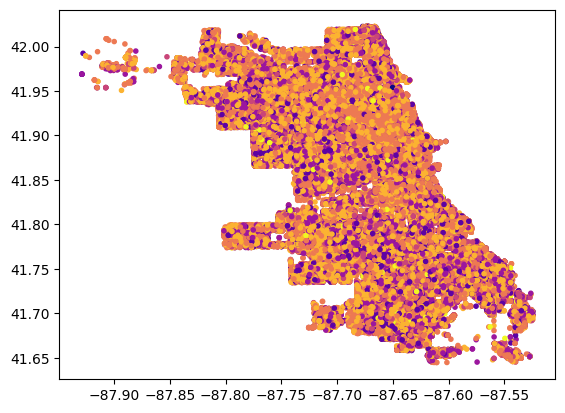

In [136]:
colormap = {0 : '#0d0887', 1 : '#5d02a4', 2 : '#9b169e', 3 : '#c94579', 
            4 : '#ed7953', 5 : '#fcb331', 6 : '#f0f821'}
plt.scatter(cleandf['Longitude'], cleandf['Latitude'], marker='.', 
            c=[colormap[i] for i in cleandf['type']])
plt.show()

In [137]:
# DO NOT RUN THIS, filtered dataset saver

# f = open('datasets/plotset.csv', 'w')
# writer = csv.writer(f)
# writer.writerow(list(cleandf.columns))
# for i in range(len(cleandf)):
#     writer.writerow(cleandf.iloc[i])
# f.close()

Now we learn how to make clusters just based on the number of clusters required

In [138]:
# making a time filter
def timeFilter(start: str, end: str) -> pd.DataFrame:
    start = dt.datetime.strptime(start, '%H:%M:%S')
    end = dt.datetime.strptime(end, '%H:%M:%S')
    if (start < end):
        return cleandf.loc[(df['Time'] >= start) & (df['Time'] < end)]
    else:
        return cleandf.loc[(df['Time'] >= start) | (df['Time'] < end)]

# examplse of if
ifs = timeFilter('17:00:00', '09:00:00')
# example of else
els = timeFilter('09:00:00','17:00:00')
# check to see if we cover everything
print(len(ifs) + len(els) == len(cleandf))
els.shape

True


(98481, 12)

In [139]:
cleandf.head()

,Primary Type,Description,Location Description,Arrest,Domestic,Location,Latitude,Longitude,Time,desc,locdesc,type
0,BATTERY,DOMESTIC BATTERY SIMPLE,APARTMENT,True,True,"[41.864073157, -87.706818608]",41.864073,-87.706819,1900-01-01 23:40:00,104,17,2
1,BATTERY,DOMESTIC BATTERY SIMPLE,RESIDENCE,False,True,"[41.782921527, -87.60436317]",41.782922,-87.604363,1900-01-01 21:40:00,104,99,2
2,PUBLIC PEACE VIOLATION,RECKLESS CONDUCT,STREET,False,False,"[41.894908283, -87.758371958]",41.894908,-87.758372,1900-01-01 23:31:00,234,114,2
3,BATTERY,SIMPLE,SIDEWALK,False,False,"[41.885686845, -87.749515983]",41.885687,-87.749516,1900-01-01 22:10:00,251,111,2
4,THEFT,$500 AND UNDER,RESIDENCE,False,True,"[41.886297242, -87.761750709]",41.886297,-87.761751,1900-01-01 22:00:00,0,99,4


In [140]:
cleandf.loc(axis=1)['Latitude':'Longitude']

,Latitude,Longitude
0,41.864073,-87.706819
1,41.782922,-87.604363
2,41.894908,-87.758372
3,41.885687,-87.749516
4,41.886297,-87.761751
...,...,...
250727,41.849222,-87.691556
250728,41.760744,-87.633335
250729,41.779235,-87.685207
250730,41.745252,-87.552773


In [141]:
from sklearn.cluster import *
def one():
    nCluster = int(input())
#    color = list(np.random.choice(range(256), size=nCluster))
    model = KMeans(n_clusters=nCluster)
    results = model.fit_predict(cleandf.loc(axis=1)['Latitude':'Longitude'])
#    plt.scatter(cleandf['Longitude'], cleandf['Latitude'], marker='.', 
#                c=[color[i] for i in results])
    return results

In [142]:
results = one()
color = list(np.random.choice(range(256), size=len(set(results))))
cleandf['cluster'] = results

In [143]:
from scipy.spatial import Delaunay
def alpha_shape(points, alpha, only_outer=True):
    assert points.shape[0] > 3, "Need at least four points"
    def add_edge(edges, i, j):
        if (i, j) in edges or (j, i) in edges:
            assert (j, i) in edges, "Can't go twice over same directed edge right?"
            if only_outer:
                edges.remove((j, i))
            return
        edges.add((i, j))
    tri = Delaunay(points)
    edges = set()
    for ia, ib, ic in tri.vertices:
        pa = points[ia]
        pb = points[ib]
        pc = points[ic]
        a = np.sqrt((pa[0] - pb[0]) ** 2 + (pa[1] - pb[1]) ** 2)
        b = np.sqrt((pb[0] - pc[0]) ** 2 + (pb[1] - pc[1]) ** 2)
        c = np.sqrt((pc[0] - pa[0]) ** 2 + (pc[1] - pa[1]) ** 2)
        s = (a + b + c) / 2.0
        area = np.sqrt(s * (s - a) * (s - b) * (s - c))
        circum_r = a * b * c / (4.0 * area)
        if circum_r < alpha:
            add_edge(edges, ia, ib)
            add_edge(edges, ib, ic)
            add_edge(edges, ic, ia)
    return edges

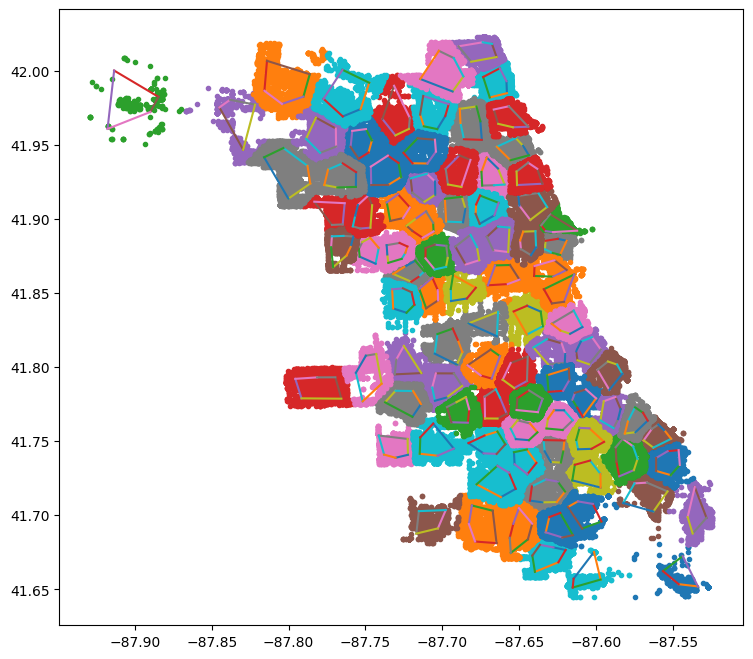

In [148]:
import warnings
warnings.filterwarnings("ignore")
# Plotting the output
fig, ax = plt.subplots(figsize=(30, 8))
for i in range(len(set(results))):
    fildf = cleandf[cleandf['cluster'] == i]
    nmod = KMeans(int(np.power(len(fildf), 0.25)))
    nmod.fit([[i, j] for i, j in zip(fildf['Longitude'], fildf['Latitude'])])
    centers = nmod.cluster_centers_
    points = np.array([[i, j] for i, j in zip(fildf['Longitude'], fildf['Latitude'])])
    try:
        edges = alpha_shape(centers, alpha=4, only_outer=True)
    except:
        continue
    plt.subplot(1, 3, 1)
    plt.plot(points[:, 0], points[:, 1], '.')
    # USE EDGES AND CENTERS TO PLOT NORMAL ROUTES, REMOVE POINTS AND ALL REFERENCES IN FINAL CODE
    for i, j in edges:
        plt.plot(centers[[i, j], 0], centers[[i, j], 1])
plt.show()

In [1]:
from modularCluster import *

city = "San Francisco"
start = '08:45:00'
end = '17:35:00'
n = 85
df = assign(city)
timedf = timeFilter(df, start, end)
hm = genHeatMap(timedf)
longs, lats = analyze(timedf, n)
lats

[[37.77210378320574, 37.77113695904762],
 [37.774284417396906, 37.776896877280336],
 [37.776896877280336, 37.778155887051284],
 [37.77113695904762, 37.774284417396906],
 [37.775519461923075, 37.77210378320574],
 [37.778155887051284, 37.775519461923075],
 [37.740683429538464, 37.73889697126316],
 [37.735082095783135, 37.73583948746988],
 [37.73889697126316, 37.735082095783135],
 [37.73583948746988, 37.740683429538464],
 [37.788815427810654, 37.79167293078125],
 [37.787250071809524, 37.788815427810654],
 [37.789573401020405, 37.787250071809524],
 [37.79167293078125, 37.79397530625],
 [37.79397530625, 37.789573401020405],
 [37.7530089845, 37.75591308459016],
 [37.76209040842857, 37.76065978138462],
 [37.76065978138462, 37.7530089845],
 [37.75591308459016, 37.76209040842857],
 [37.71595865727273, 37.71545370494565],
 [37.71049518188235, 37.71595865727273],
 [37.71095911384615, 37.71049518188235],
 [37.71545370494565, 37.71095911384615],
 [37.775178382622954, 37.77388895773438],
 [37.770485

In [2]:
import plotly.express as px
import plotly.graph_objects as go
import numpy as np

fig = go.Figure(go.Scattermapbox(
    mode = "markers+lines"))

for i in range(len(lats)):
    fig.add_trace(go.Scattermapbox(
        mode = "markers+lines",
        lon = longs[i],
        lat = lats[i],
        marker = {'size': 10, 'color' : 'blue'}))

fig.update_layout(
    margin ={'l':15,'t':5,'b':5,'r':15},
    mapbox = {
        'center': {'lon': np.average(longs), 'lat': np.average(lats)},
        'style': "stamen-terrain",
        'center': {'lon': np.average(longs), 'lat': np.average(lats)},
        'zoom': 11.2},
    showlegend=False)

fig.write_html("webapp/frontend/graph.html")


In [3]:
hm = genHeatMap(timeFilter(timedf, start, end))
hm.write_html('webapp/frontend/heatmap.html')